# JSL49_01 (CF-900)

In [172]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
## Preparing some stuff
# Libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib, json, codecs, scipy, scipy.constants
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import scipy.fftpack
from IPython.core.display import display, HTML
import mjsplot as mplt
import dateutil

# Display
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Physical constants
e = scipy.constants.e
k_B = scipy.constants.Boltzmann
h = scipy.constants.h
hbar = scipy.constants.hbar
Rk = h/e**2
Phi_0 = h/e # Flux quantum

# Load data
d = {}
df = {}
def loadin(filename,folder='data'): # a way to load in many different files and keep track of them.
    if 'jsonl' in filename:
        datafile = open('../'+folder+'/'+filename, 'r').read()
        key = filename[-15:-11]
        data = [json.loads(str(item)) for item in datafile.strip().split('\n')]
        full,i = {},0
        for dic in data:
            for k,v in dic.items():
                if i==0:
                    full[k] = [v]
                else:
                    full[k] += [v]
            i += 1
        d[key]= full
        df[key] = pd.DataFrame(full)
    else:
        datafile = json.loads( codecs.open('../'+folder+'/'+filename,'r','utf-8').read() )
        key = datafile['attr']['_file counter']
        d[key]= datafile
        df[key] = pd.DataFrame(datafile['data'])

# Find best match
def find_nu(Bsdh):
    nu = np.linspace(20,1,20)
    Bnu = Phi_0/nu
    Bnu_diff = [t/s for s, t in zip(Bnu, Bnu[1:])]
    Bsdh_diff = np.array([t/s for s, t in zip(Bsdh, Bsdh[1:])])
    size_part = len(Bsdh_diff)
    residuals = [np.sum(Bnu_diff[i:i+size_part]-Bsdh_diff) for i in range(len(Bnu_diff)-size_part+1)]
    idx = np.argmin(np.abs(residuals))
    return nu[idx:idx+len(Bsdh)]

# Extract single subband density and density
def single_subband(Bsdh_all,r_df):
    n_band, mu_band, nu_band = [],[],[]
    for vgt,Bsdh in Bsdh_all.items():
        # Find best matching filling factors
        nu = find_nu(Bsdh)
        n = np.mean(Bsdh*nu/Phi_0)*1e-4 
        if isinstance(r_df, pd.DataFrame):
            mu = 1/(r_df[r_df['v'] == vgt]['rho'].values[0] * n * e)
        elif isinstance(r_df, float):
            mu = 1/(r_df * n * e)
        else:
            raise TypeError('r_df should be a pd.Dataframe or a float (when supplying rho_xx directly).')
        B_nu = n*1e4*Phi_0/nu
        nu_band.append(nu)
        n_band.append(n)
        mu_band.append(mu)
    return [nu_band,n_band,mu_band],[B_nu,nu]

# Plot single subband extracted from SdH
def plot_subband_gate(v_tot,n_tot,band1,colors=None,save=False,rows=1,cols=3):
    """
        TODO
    """
    [nu_band1, n_band1, mu_band1] = band1
    fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(7*cols,5*rows))
    axes = [ax[0]]*3+[ax[1]]+[ax[2]]
    plots = [([vgt for vgt,_ in Bsdh_all.items()], np.array(n_band1)*10),
             (v_tot, np.array(n_tot)-np.array(n_band1)),
             (v_tot, n_tot),
             ([vgt for vgt,_ in Bsdh_all.items()],mu_band1),
             (n_band1,mu_band1)]
    labels = ['Subband 1 (10x)','Subband 2','Total','','']
    linestyles = ['o-','o-','v-','o-','o-']
    if not colors:
        colors = ['green','blue','cyan','green','green']
    axes_labels = [('Vgate / V',u'Density / cm$^{2}$'),('Vgate / V',u'Density / cm$^{2}$'),
                   ('Vgate / V',u'Density / cm$^{2}$'),('Vgate / V',u'Mobility / cm$^{2}$/Vs'),
                   (u'Density / cm$^{2}$)',u'Mobility / cm$^{2}$/Vs')]
    titles = ['Densities of both subbands vs gate']*3+['Mobility of subband 1']+['Mobility subband 1 vs density']
        
    for axis,plot,label,ls,color,axis_labels,title in zip(axes,plots,labels,linestyles,colors,axes_labels,titles):
        axis.plot(*plot,ls,label=label)
        axis.set_xlabel(axis_labels[0])
        axis.set_ylabel(axis_labels[1])
        axis.set_title(title)
        axis.grid(which='major')
    fig.legend(loc='upper left', bbox_to_anchor=(0.05,0.9))
    fig.tight_layout()
    if save:
        fig.savefig('../plots/'+save)

# QTplot compatibility
def _mlog(s,quite):
    if not quite:
        print(s)
def _saveBackwardsCompatableFiles(file_path,d,quite=True):
    _mlog('save backwards files for compatability',quite)
    #df = pd.DataFrame(d['data'])
    shortFilepath = file_path[:-5]
    the_time = dateutil.parser.parse(d['attr']['_time start'])
    _mlog('Making a .set file',quite)
    s ='Filename: '+ shortFilepath.split('\\')[-1] + '\n'
    s += 'Timestamp: ' + the_time.strftime("%a %b %d %H:%M:%S %Y") + '\n\n'
    for device in d['attr']['_devices start']:
        s+= 'Instrument: ' + str(device) + ' \n'
        for setting in d['attr']['_devices start'][device]:
            s += '\t' + str(setting) + ': ' + str(d['attr']['_devices start'][device][setting]) +'\n'

    with open(shortFilepath+'.set', 'w') as f:
        f.write(s)
     
    
    _mlog('Making a .dat file',quite)
    s  ='# Filename: '+ shortFilepath.split('\\')[-1]+'.dat' + '\n'
    s += '# Timestamp: ' +  the_time.strftime("%a %b %d %H:%M:%S %Y") + '\n\n'
    i=1; #keep track of column numbers
    keys = []
    #for k in d['attr']['_coordinates']:
    for k_idx in range(len(d['attr']['_coordinates'])):
        k = d['attr']['_coordinates'][k_idx]['name']
        keys.append(k)
        s += '# Column ' + str(i) +":\n"
        s+= '#\tend: '+str(d['attr']['_coordinates'][k_idx]['max']) + '\n'
        s+= '#\tname: '+ str(k) + '\n'
        s+= '#\tsize: '+ str(d['attr']['_coordinates'][k_idx]['size']) + '\n'
        s+= '#\tstart: '+ str(d['attr']['_coordinates'][k_idx]['min']) + '\n'
        s += '#\ttype: coordinate\n'
        i+=1
    cordnames = [ el['name'] for el in d['attr']['_coordinates'] ] 
    for col in d['data']:
        if col not in cordnames:
            keys.append(col)
            s += '# Column ' + str(i) +":\n"
            s += '#\tname: ' + str( col ) +"\n"
            s += '#\ttype: value\n'
            i += 1
    
    s+= '\n'
    #try to remove this line
    #s += df.to_csv(sep='\t' ,columns = keys, index=False, header=False)
    maxl = len(d['data'][keys[0]])
    l=0
    linetext = []
    while l < maxl:
        for j in range(len(keys)):
            linetext.append (  str( d['data'][keys[j]][l] ) )
        s += '\t'.join(linetext) + '\n'
        linetext = []
        l+=1
    
    with open(shortFilepath+'.dat', 'w') as f:
        f.write(s)
        
    _mlog('Making a .meta.txt file',quite)
    s = ''
    i=0
    if '_coordinates' in d['attr']:
        #for k in d['attr']['_coordinates']:
        for k_index in range(len(d['attr']['_coordinates'])):
            s+= str(d['attr']['_coordinates'][k_index]['size']) + '\n'
            s+= str(d['attr']['_coordinates'][k_index]['min']) + '\n'
            s+= str(d['attr']['_coordinates'][k_index]['max']) + '\n'
            s+= str(d['attr']['_coordinates'][k_index]['name']) + '\n'
            i+=1
        for col in d['data']:
            if col not in cordnames:
                # it is a value not a coordinates
                i+=1
                s+= str(i) + '\n'
                s+= str(col)+ '\n'
    with open(shortFilepath+'.meta.txt', 'w') as f:
        f.write(s)

# Hallbar 1

## Density and mobility, raw data at Vgate = 0

Density and mobility from Rxy:
n = 3.49e+12 cm^-2
mu = 12323.58 cm^2/Vs


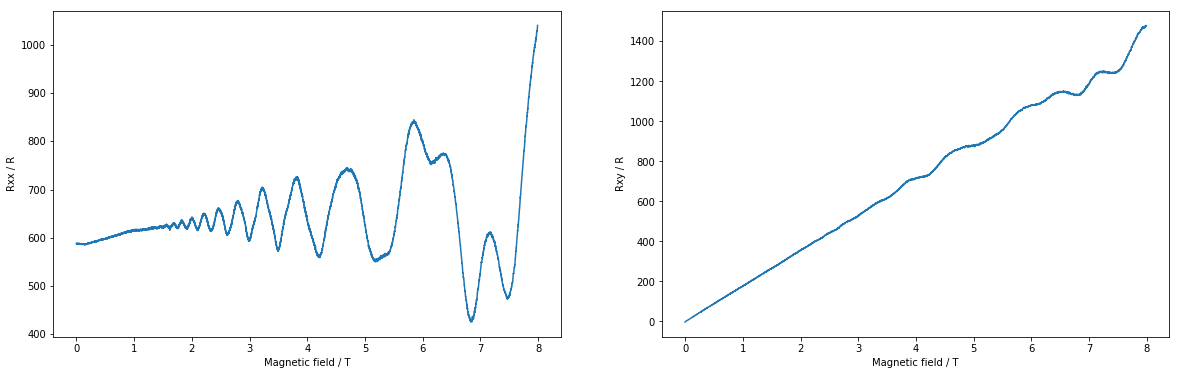

In [851]:
## Load data
loadin("20180625T120910889Z-0009.json")

Rxx = (df['0009']['DC Voltage xx / V'][:9466]+0.0840319348*1e-3)/1e-7
Rxy = (df['0009']['DC Voltage xy / V'][:9466]+0.0849385834*1e-3)/1e-7
Bmeas = df['0009']['Measured Field / T'][:9466]

rho = 581/4

## Plot
fig_1b, ax_1b = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
for ax,plot,ylbl in zip(ax_1b,[(Bmeas,Rxx),(Bmeas,Rxy)],['Rxx / R','Rxy / R']):
    ax.plot(*plot)
    ax.set_xlabel('Magnetic field / T')
    ax.set_ylabel(ylbl)
    
# Save figure
plt.savefig('../plots/hallbar1_rxx_rxy.png')

## Overal density and mobility
n_total = 1/179/e ## Rxy slope
mu_total = 1/(rho*n_total*1e-4*e)
print('Density and mobility from Rxy:\nn = {0:.2e} '.format(n_total*1e-4)+'cm^-2')
print('mu'+' = {0:.2f} '.format(mu_total)+'cm^2/Vs')

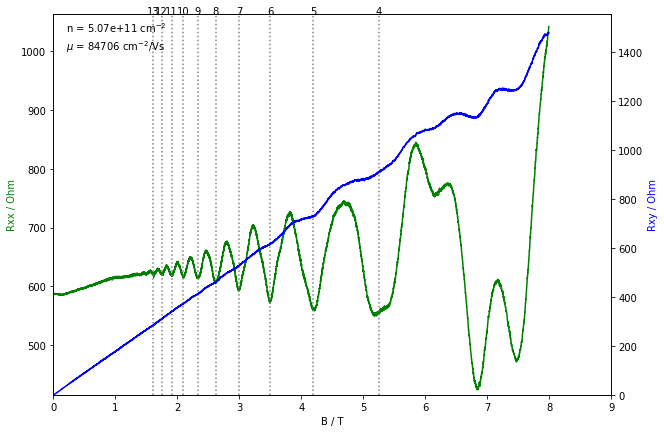

In [787]:
## Filling factors
# B_extra = [6.89277944]
Bsdh = {0:[1.62,1.75,1.91,2.1,2.33,2.62,3,3.5,4.2,5.2]} # Shubnikov- de Haas minima from Rxy

[nu_band1, n_band1, mu_band1], [B_nu,nu_all] = single_subband(Bsdh,rho)

## Make overview plot
fig_1c, ax_1c = plt.subplots(figsize=(10,7))
xmax = [min(Rxx)*0.98,0]
ymax = [max(Rxx)*1.02,max(Rxy)*1.05]
for ax,ylims,f,color,label in zip([ax_1c,ax_1c.twinx()],
                    [(xmax[0],ymax[0]),(xmax[1],ymax[1])],
                    [Rxx,Rxy],['green','blue'],
                    ['Rxx / Ohm','Rxy / Ohm']):
    ax.set_xlim(0,9)
    ax.set_ylim(*ylims)
    ax.plot(Bmeas,f,color=color)
    ax.set_xlabel('B / T')
    ax.set_ylabel(label,color=color)

# Density and mobility annotation
ax_1c.annotate('n = {0:.2e} '.format(n_band1[0])+u'cm$^{-2}$',(0.2,ymax[0]-30))
ax_1c.annotate(u'${\mu}$'+' = {0:.0f} '.format(mu_band1[0])+u'cm$^{-2}$/Vs',(0.2,ymax[0]-60))

# Filling factors
for xc,nuc in zip(B_nu,nu_all):
    ax_1c.axvline(x=xc,color='gray',ls=':')
    ax_1c.annotate('{0:.0f}'.format(nuc),(xc,ymax[0]),ha="center")
    
# Save figure
fig_1c.savefig('../plots/hallbar1_subband1.png')
# print("n = {0}, mu = {1}".format(n*1e-4,mu))

## Magnetic field up to 9T with topgate

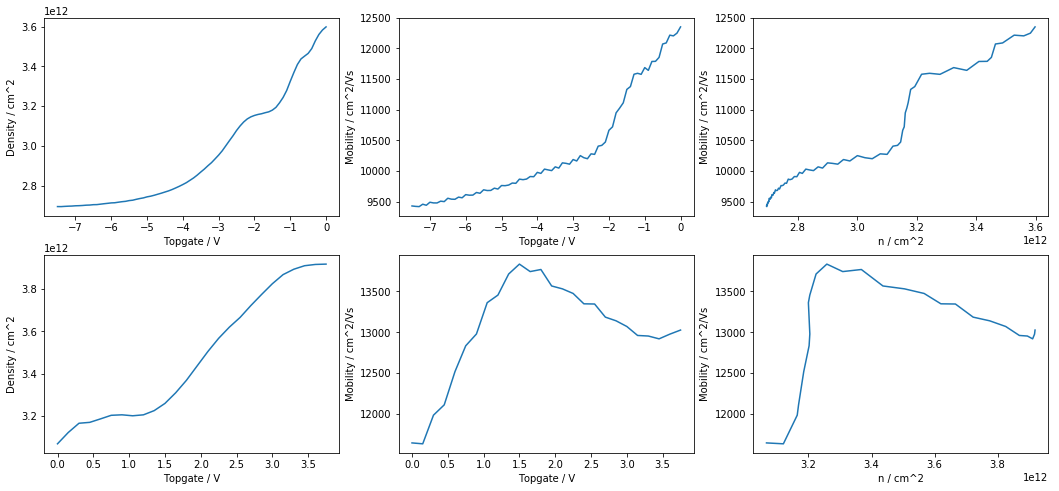

In [818]:
## Load data (not corrected for geometry)
loadin("20180626T145647604Z-0033.json")
loadin("20180627T052100545Z-0034.json")

# Get density
r_df_1a  = pd.DataFrame()
dc_current = 1e-7
for label,group in df['0033'].groupby('Topgate Voltage / V'):
    [b,a] = np.polyfit(group['Magnet Z / T'],group['DC Voltage xy / V']/dc_current,1)
    Vxx = group[group['Magnet Z / T'] == 0.]['DC Voltage xx / V'].values[0]+8.6134e-5
    r_df_1a = r_df_1a.append({'a':a,'b':b,'n':1/(e*b)*1e-4,'v':label,'Vxx':Vxx},ignore_index=True)
# Get mobility
r_df_1a['rho'] = r_df_1a['Vxx']/(dc_current * 4) # Mesa contains 4 squares
r_df_1a['mu'] = 1/(r_df_1a['rho']*r_df_1a['n']*e)

# Get density
r_df_1b  = pd.DataFrame()
dc_current = 1e-7
for label,group in df['0034'].groupby('Topgate Voltage / V'):
    [b,a] = np.polyfit(group['Magnet Z / T'],group['DC Voltage xy / V']/dc_current,1)
    Vxx = group[group['Magnet Z / T'] == 0.]['DC Voltage xx / V'].values[0]+8.6134e-5
    r_df_1b = r_df_1b.append({'a':a,'b':b,'n':1/(e*b)*1e-4,'v':label,'Vxx':Vxx},ignore_index=True)
    
# Get mobility
r_df_1b['rho'] = r_df_1b['Vxx']/(dc_current * 4) # Mesa contains 4 squares
r_df_1b['mu'] = 1/(r_df_1b['rho']*r_df_1b['n']*e)

## Plot
fig_1a, ax_1a = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

subplots_1a = [(r_df_1a['v'],r_df_1a['n']),(r_df_1a['v'],r_df_1a['mu']),(r_df_1a['n'],r_df_1a['mu']),
              (r_df_1b['v'],r_df_1b['n']),(r_df_1b['v'],r_df_1b['mu']),(r_df_1b['n'],r_df_1b['mu'])]
labels_1a = [['Topgate / V','Density / cm^2'],['Topgate / V', 'Mobility / cm^2/Vs'], ['n / cm^2','Mobility / cm^2/Vs'],
            ['Topgate / V','Density / cm^2'],['Topgate / V', 'Mobility / cm^2/Vs'], ['n / cm^2','Mobility / cm^2/Vs']]

for col,subplot,label in zip(sum(ax_1a.tolist(),[]),subplots_1a,labels_1a):
    col.plot(*subplot)
    col.set_xlabel(label[0])
    col.set_ylabel(label[1])

# Save figure
fig_1a.savefig('../plots/hallbar1_mobilty_density.png')

## Track individual subbands with gate

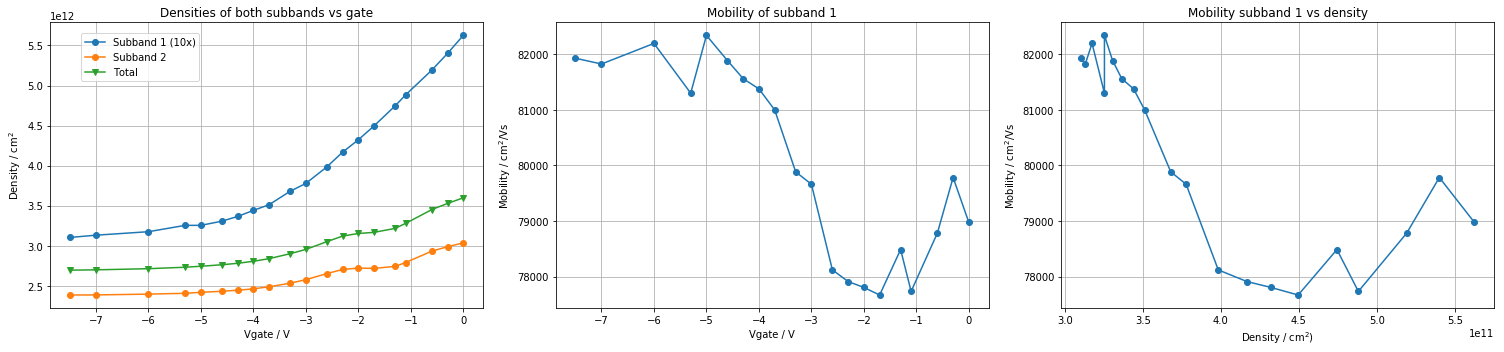

In [819]:
Bsdh_all = {}
vgate = [0,-.3,-.6,-1.1,-1.3,-1.7,-2,-2.3,-2.6,-3,-3.3,-3.7,-4,-4.3,-4.6,-5,-5.3,-6,-7,-7.499999999999999]
dips = [[1.94,2.13,2.33,2.58,2.91,3.3],[2.03,2.23,2.5,2.78,3.2,3.71],[2.15,2.4,2.67,3.07,3.57],[2.02,2.25,2.5,2.89,3.38],[1.98,2.18,2.45,2.8,3.25],
       [1.86,2.07,2.3,2.67,3.11],[1.79,1.99,2.23,2.55,2.98],[1.91,2.15,2.45,2.9,3.45],[1.67,1.83,2.05,2.34,2.74],[1.73,1.97,2.25,2.6,3.09],
        [1.52,1.7,1.92,2.15,2.53],[1.46,1.6,1.82,2.07,2.43],[1.43,1.57,1.78,2.03,2.38],[1.54,1.74,2,2.32,2.78],[1.52,1.71,1.95,2.27,2.75],
        [1.5,1.69,1.92,2.24,2.68],[1.5,1.69,1.92,2.24,2.68],[1.45,1.65,1.88,2.2,2.61],[1.63,1.84,2.17,2.58,3.23],[1.44,1.6,1.83,2.15,2.54]]
Bsdh_all = {key: value for key,value in zip(vgate,dips)}

# Get density from Rxx data (single channel)
[nu_band1, n_band1, mu_band1],_ = single_subband(Bsdh_all,r_df_1a)
    
# Get densities from Rxy data (all channels combined) 
v_tot = [r_df_1a[r_df_1a['v'] == vgate]['v'].values[0] for vgate,_ in Bsdh_all.items()]  
n_tot = [r_df_1a[r_df_1a['v'] == vgate]['n'].values[0] for vgate,_ in Bsdh_all.items()]

plot_subband_gate(v_tot,n_tot,[nu_band1, n_band1, mu_band1],save='hallbar1_single_subband_negative_topgate_gate-sweeps.png')

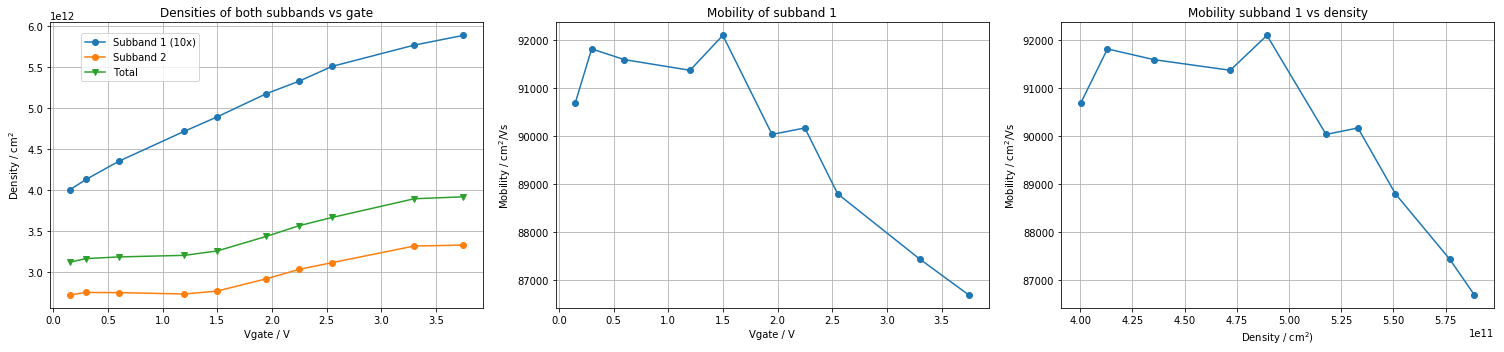

In [820]:
# Positive Vgate dataset 20180627T052100545Z-0034.json
Bsdh_all = {}
vgate = [.15,.3,.6,1.2,1.5,1.95,2.25,2.55,3.3,3.7499999999999996]
dips = [[2.09,2.36,2.73,3.32],[1.9,2.13,2.45,2.84],[1.81,2,2.24,2.57],[1.94,2.17,2.45,2.79],[1.85,2.03,2.24,2.52],[1.94,2.16,2.38,2.67,3.05],
       [2.2,2.45,2.76,3.15],[2.08,2.27,2.53,2.85],[2.17,2.38,2.65,2.99],[2.22,2.42,2.71,3.05],[1.78,1.92,2.09,2.26,2.49]]
Bsdh_all = {key: value for key,value in zip(vgate,dips)}

# Get density from Rxx data (single channel)
[nu_band1, n_band1, mu_band1],_ = single_subband(Bsdh_all,r_df_1b)

# Get densities from Rxy data (all channels combined) 
v_tot = [r_df_1b[r_df_1b['v'] == vgate]['v'].values[0] for vgate,_ in Bsdh_all.items()]  
n_tot = [r_df_1b[r_df_1b['v'] == vgate]['n'].values[0] for vgate,_ in Bsdh_all.items()]

plot_subband_gate(v_tot,n_tot,[nu_band1, n_band1, mu_band1],save='hallbar1_single_subband_positive_topgate_gate-sweeps.png')

## Processed Vxy data

In [600]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/dbouman1/2deg/master/img/qh_xy_deriv.png")

## Bfield sweeps vs gate

In [44]:
## Load data
loadin("20180628T180227174Z-0052.json")

In [45]:
## Separate up and down sweeps
df['0052']['Direction'] = np.sign( np.gradient(df['0052']['Measured Field / T'].values) )
tdf = df['0052'][df['0052']['Measured Field / T'] > -0.085]
up_tdf=tdf[tdf['Direction'] > 0 ]
down_tdf = tdf[tdf['Direction'] < 0 ]

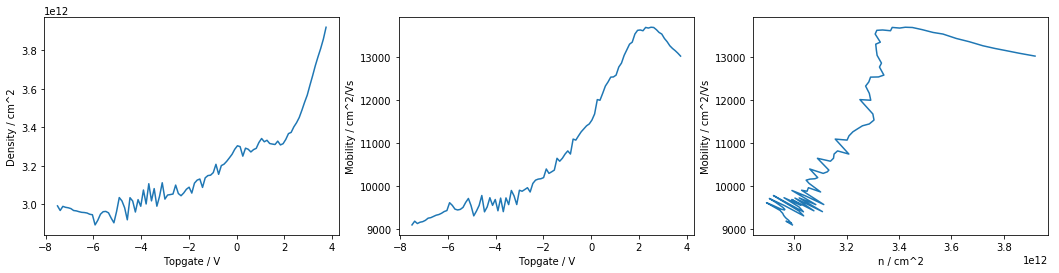

In [816]:
# Get density
r_df_1f  = pd.DataFrame()
ac_current = 10e-9
for label,group in up_tdf.groupby('Topgate Voltage / V'):
    [b,a] = np.polyfit(group['Measured Field / T'],group['AC Voltage xy / V']/ac_current,1)
    Vxx = group.iloc[group['Measured Field / T'].abs().argsort()[:1]]['AC Voltage xx / V'].values[0]
    r_df_1f = r_df_1f.append({'a':a,'b':b,'n':1/(e*b)*1e-4,'v':label,'Vxx':Vxx},ignore_index=True)
    
# Calculate mobility
r_df_1f['rho'] = r_df_1f['Vxx']/(ac_current * 4) # Mesa contains 4 squares
r_df_1f['mu'] = 1/(r_df_1f['rho']*r_df_1f['n']*e)

## Plot
fig_1f, ax_1f = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

subplots_1f = [(r_df_1f['v'],r_df_1f['n']),(r_df_1f['v'],r_df_1f['mu']),(r_df_1f['n'],r_df_1f['mu'])]
labels_1f = [['Topgate / V','Density / cm^2'],['Topgate / V', 'Mobility / cm^2/Vs'], ['n / cm^2','Mobility / cm^2/Vs']]

for col,subplot,label in zip(ax_1f,subplots_1f,labels_1f):
    col.plot(*subplot)
    col.set_xlabel(label[0])
    col.set_ylabel(label[1])

# Save figure
fig_1f.savefig('../plots/hallbar1_mobilty_density_2.png')

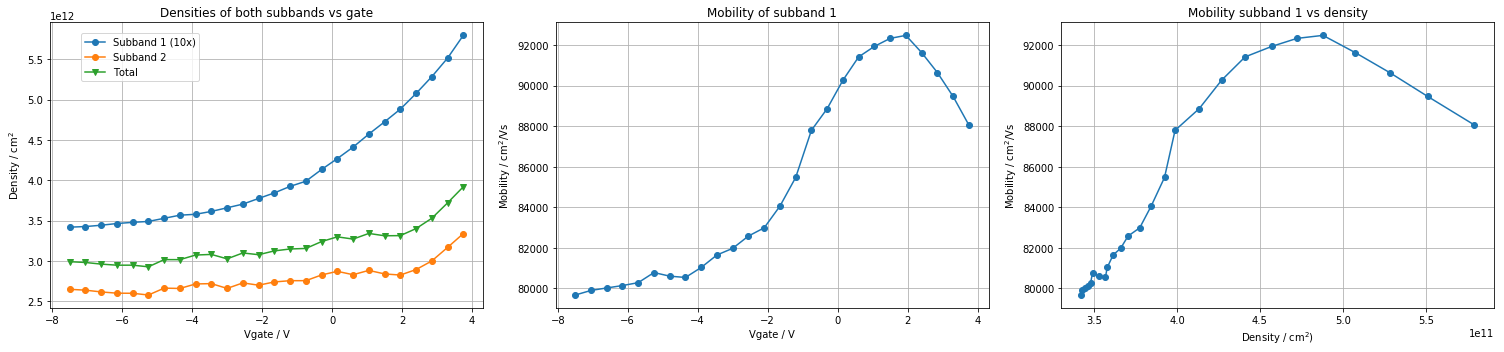

In [817]:
## Vgate dataset 0052
vgate = df['0052']['Topgate Voltage / V'].unique()[::4]
Bsdh_all = {}
dips = [[1.85,1.99,2.18,2.4,2.66,2.99],[1.75,1.9,2.07,2.29,2.53,2.85],[1.68,1.82,1.99,2.18,2.43,2.73],[1.75,1.91,2.1,2.33,2.62],
                    [1.68,1.84,2.02,2.24,2.52],[1.63,1.78,1.95,2.16,2.45],[1.58,1.72,1.88,2.1,2.37],[1.52,1.66,1.82,2.03,2.28],
                    [1.96,2.21,2.53,2.94,3.52],[1.56,1.71,1.9,2.13,2.44,2.85],[1.36,1.5,1.66,1.84],[1.48,1.63,1.8,2.03,2.31,2.7],
                    [1.45,1.58,1.77,1.99,2.27],[1.42,1.55,1.75,1.95,2.23,2.6],[1.39,1.53,1.7,1.92,2.19,2.56],[1.37,1.51,1.68,1.9,2.17],
                    [1.35,1.49,1.66,1.87,2.15,2.5],[1.34,1.48,1.64,1.85,2.12,2.48],[2.1,2.47,2.95],[1.81,2.08,2.45,2.93],[1.2,1.31,1.45],
                    [2.9,3.57],[1.3,1.43,1.6,1.79],[1.43,1.58,1.78,2.03],[1.42,1.575,1.773,2.02],[1.29,1.41,1.57,1.77,2.02]]
Bsdh_all = {key: value for key,value in zip(vgate,dips)}
   
# Get density from Rxx data (single channel)
[nu_band1, n_band1, mu_band1],_ = single_subband(Bsdh_all,r_df_1f)

# Get densities from Rxy data (all channels combined) 
v_tot = [r_df_1f[r_df_1f['v'] == vgt]['v'].values[0] for vgt,_ in Bsdh_all.items()]  
n_tot = [r_df_1f[r_df_1f['v'] == vgt]['n'].values[0] for vgt,_ in Bsdh_all.items()]

plot_subband_gate(v_tot,n_tot,[nu_band1, n_band1, mu_band1],save='hallbar1_single_subband_full_topgate.png')

### Export processed data

In [ ]:
export_json = False
if export_json:
    # Add to original dataset
    dout_json = d['0052']
    dout_json['data_up'] = up_tdf.to_dict(orient='list')
    dout_json['data_down'] = down_tdf.to_dict(orient='list')
    # Export json file
    with open('../processed/20180628T180227174Z-0052_processed_up_down_sweep.json', 'w') as outfile:
        json.dump(dout_json, outfile)

# QTplot data file
dout = d['0052']
dout['data'] = up_tdf.to_dict(orient='list')
# _saveBackwardsCompatableFiles('../processed/updata',dout,quite=False)

for column in df['0052']:
#     print(len(df['0052'][][column]))

## Redo Bfield sweep data (sample was thermally cycled 2 times to 4K)

In [49]:
loadin('20180709T061423208Z-0108.json')

In [62]:
## Separate up and down sweeps
df['0108']['Direction'] = np.sign( np.gradient(df['0108']['Measured Field / T'].values) )
tdf = df['0108'][df['0108']['Measured Field / T'] > -0.007]
up_tdf=tdf[tdf['Direction'] > 0 ]
down_tdf = tdf[tdf['Direction'] < 0 ]

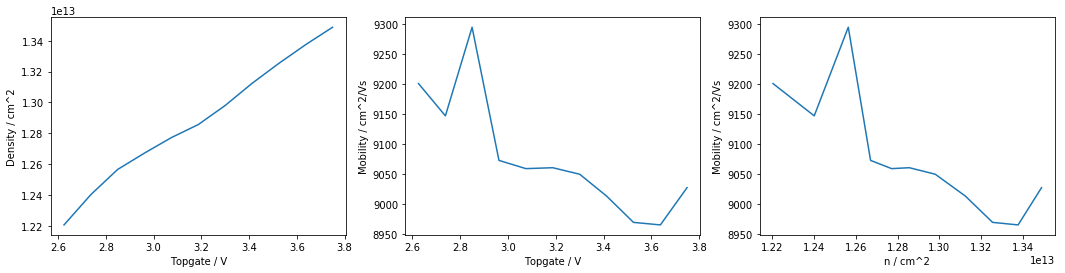

In [64]:
# Get density
r_df_1g  = pd.DataFrame()
ac_current = 10e-9
for label,group in up_tdf.groupby('Topgate Voltage / V'):
    [b,a] = np.polyfit(group['Measured Field / T'],group['AC Voltage xy / V']/ac_current,1)
    Vxx = group.iloc[group['Measured Field / T'].abs().argsort()[:1]]['AC Voltage xx / V'].values[0]
    r_df_1g = r_df_1g.append({'a':a,'b':b,'n':1/(e*b)*1e-4,'v':label,'Vxx':Vxx},ignore_index=True)
    
# Calculate mobility
r_df_1g['rho'] = r_df_1g['Vxx']/(ac_current * 4) # Mesa contains 4 squares
r_df_1g['mu'] = 1/(r_df_1g['rho']*r_df_1g['n']*e)

## Plot
fig_1g, ax_1g = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

subplots_1g = [(r_df_1g['v'],r_df_1g['n']),(r_df_1g['v'],r_df_1g['mu']),(r_df_1g['n'],r_df_1g['mu'])]
labels_1g = [['Topgate / V','Density / cm^2'],['Topgate / V', 'Mobility / cm^2/Vs'], ['n / cm^2','Mobility / cm^2/Vs']]

for col,subplot,label in zip(ax_1g,subplots_1g,labels_1g):
    col.plot(*subplot)
    col.set_xlabel(label[0])
    col.set_ylabel(label[1])

# Save figure
fig_1g.savefig('../plots/hallbar1_mobilty_density_3.png')

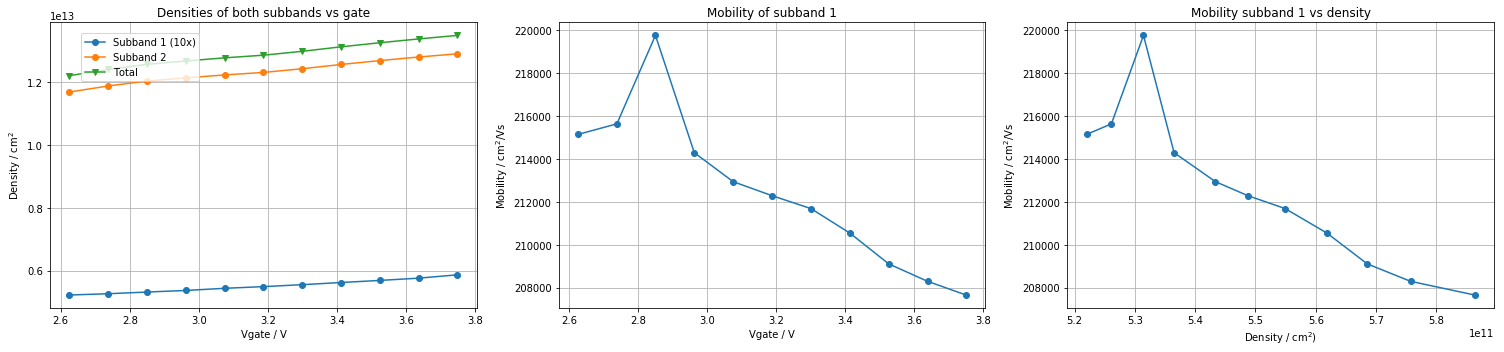

In [68]:
vgate = df['0108']['Topgate Voltage / V'].unique()
Bsdh_all = {}
dips = [[2.02,2.21,2.4,2.7,3.05],[1.83,1.97,2.17,2.39,2.65],[1.96,2.14,2.35,2.61],
       [1.79,1.94,2.11,2.32,2.58],[1.76,1.92,2.08,2.3,2.55],[1.75,1.89,2.06,2.27,2.52],
       [1.72,1.88,2.04,2.25,2.5],[1.70,1.85,2.01,2.23,2.47],[1.69,1.83,2.,2.2,2.44],
       [1.67,1.81,1.98,2.18,2.42],[1.66,1.8,1.96,2.16,2.4]]
Bsdh_all = {key: value for key,value in zip(vgate,dips)}
   
# Get density from Rxx data (single channel)
[nu_band1, n_band1, mu_band1],_ = single_subband(Bsdh_all,r_df_1g)

# Get densities from Rxy data (all channels combined) 
v_tot = [r_df_1g[r_df_1g['v'] == vgt]['v'].values[0] for vgt,_ in Bsdh_all.items()]  
n_tot = [r_df_1g[r_df_1g['v'] == vgt]['n'].values[0] for vgt,_ in Bsdh_all.items()]

plot_subband_gate(v_tot,n_tot,[nu_band1, n_band1, mu_band1],save='hallbar1_single_subband_partial_topgate.png')

## TODO
 - scipy grid interpolate (for backwards compatible file)

## FFT

In [186]:
def fft_SdH(cdf,x,y,start,end,N=501,xlim=200,ylim=10e-6,fit=True):
    Vxx = scipy.interpolate.interp1d(1/cdf[x],cdf[y],kind='linear')
    start, end = 1/end,1/start
    tdf = cdf[ ( 1/cdf[x] > start ) & ( 1/cdf[x] < end ) ]
    B = np.linspace(start,end,N) 
    yf = scipy.fftpack.fft(Vxx(B))
    xf = np.linspace(0.0, 1.0/(2.0*dB), N//2)
    pyf = 2.0/N * np.abs(yf[:N//2])
    
    # Plot
    fig, axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
    plots = [(B,Vxx(B)), (xf, pyf)]
    xlims = [(None,None),(0,xlim)]
    ylims = [(None,None),(0,ylim)]
    titles= ['Data','FFT spectrum']
    for ax,plot,xl,yl,title in zip(axes,plots,xlims,ylims,titles):
        ax.plot(*plot, '-',label='interp')
        ax.set_title(title)
        ax.set_xlim(*xl)
        ax.set_ylim(*yl)
    plt.show()
    
    if fit:
        xpeaks = [int(i) for i in input("X-position estimates of peaks (space separated)").split()]
        bounds = [[i-5,i+5] for i in xpeaks]    
        peaks = {}
        for bnd,i in zip(bounds,range(len(bounds))):
            idx = [np.abs(xf - a0).argmin() for a0 in bnd]
            peaks['Subband '+str(i+1)] = xf[idx[0]+np.argmax(pyf[idx[0]:idx[1]])]

        fig2, axes2 = plt.subplots(figsize=(8,5))    
        for key,peak in peaks.items():
            axes2.plot(xf, pyf, '-',label='interp')
            axes2.axvline(x=peak,color='gray',ls=':')
            axes2.set_xlim(0,xlim)
            axes2.set_ylim(0,ylim)
        plt.show()
        # Calculate densities from found peaks
        for subband,period in peaks.items():
            n = period/Phi_0
            print(subband+' density: {0:.2e}'.format(n*1e-4))
        print("Total density is {0:.2e} cm^-2".format(sum(peaks.values())/Phi_0*1e-4))

In [4]:
loadin('20180703T101454118Z-0064.json')
cdf = df['0064'][(df['0064']['i'] < 1213)] # Select the positive up-sweep data

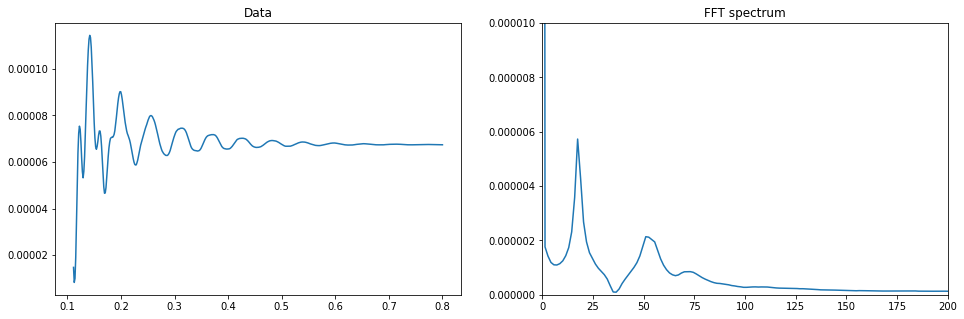

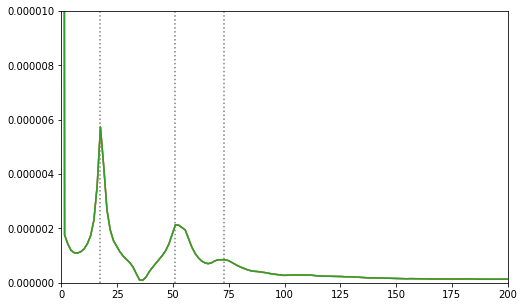

Subband 1 density: 4.24e+11
Subband 2 density: 1.24e+12
Subband 3 density: 1.77e+12
Total density is 3.43e+12 cm^-2


In [208]:
fft_SdH(cdf,'Measured Field / T','AC Voltage xx / V',1.25,8.985,N=501)

In [2]:
loadin('20180709T061423208Z-0108.json')
cdf = df['0108'][df['0108']['Stage'] == 'rampup']

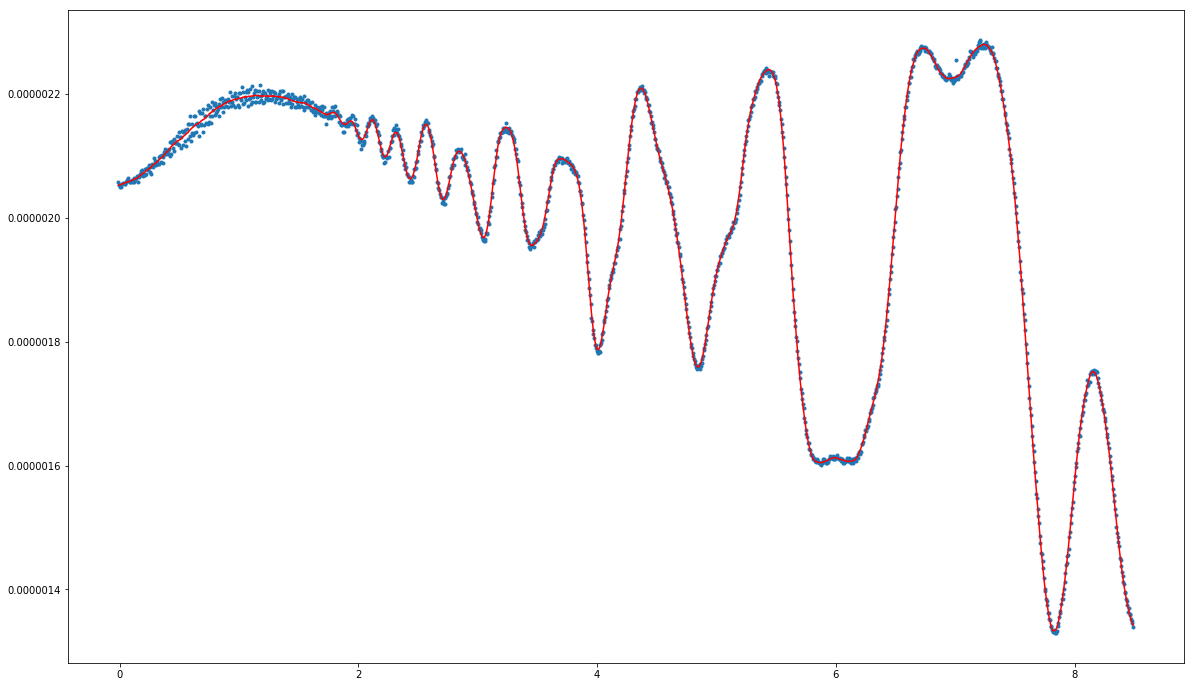

In [244]:
fig,ax = plt.subplots(figsize=(20,12))
for dat in [cdf[cdf['Topgate Voltage / V'] > 3.7]]:
    B = dat['Measured Field / T']
    Vxx = dat['AC Voltage xx / V']
ax.plot(B,Vxx,'.')
ax.plot(B,scipy.signal.savgol_filter(Vxx, 31, 3),'r')

In [11]:
loadin('20180709T061423208Z-0108.json')
cdf = df['0108'][df['0108']['Stage'] == 'rampup']

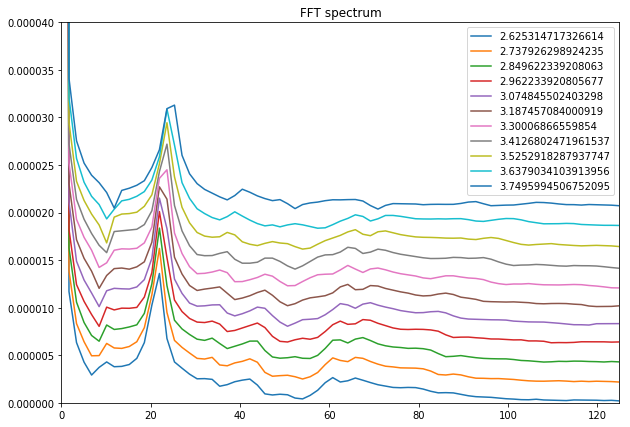

In [20]:
x,y = 'Measured Field / T','DC Voltage xx / V'
N = 501
start, end = 1/1.4,1/8.45
dB = abs(end-start)/N
offset = 0
xlim, ylim = 125, 4e-5
B = np.linspace(start,end,N)
fig, ax = plt.subplots(figsize=(10,7))
for lbl,grp in cdf.groupby('Topgate Voltage / V'):
    Vxx = scipy.interpolate.interp1d(1/grp[x],grp[y],kind='linear')
    tdf = grp[ ( 1/grp[x] > start ) & ( 1/grp[x] < end ) ]
    yf = scipy.fftpack.fft(scipy.signal.savgol_filter(Vxx(B), 5, 3))
    xf = np.linspace(0.0, 1.0/(2.0*dB), N//2)
    pyf = 2.0/N * np.abs(yf[:N//2]) + offset

    # Plot    
    ax.plot(xf, pyf, '-',label=lbl)
    offset += 2e-6

ax.set_xlim(0,xlim)
ax.set_ylim(0,ylim)
ax.set_title('FFT spectrum')
plt.legend()

2.625314717326614


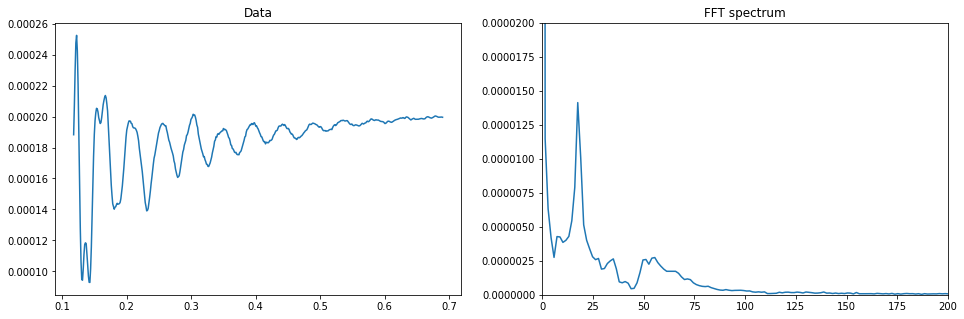

2.737926298924235


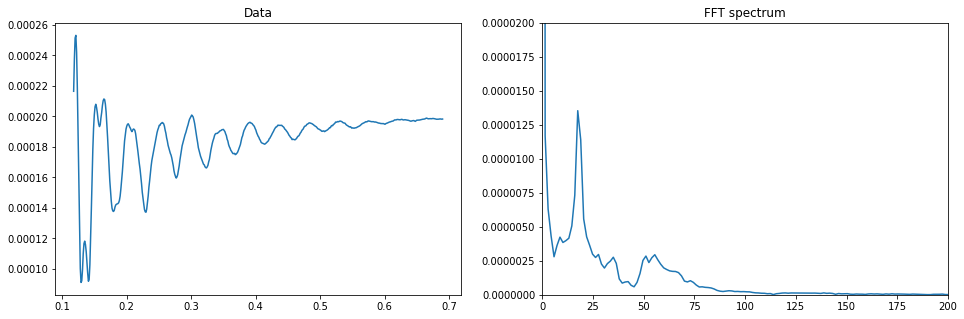

2.849622339208063


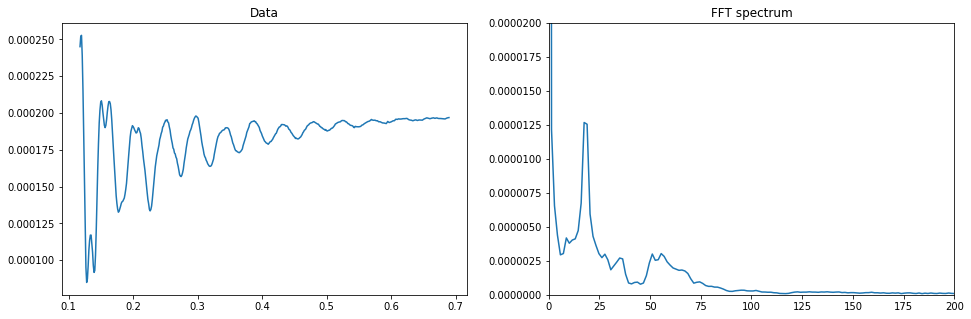

2.962233920805677


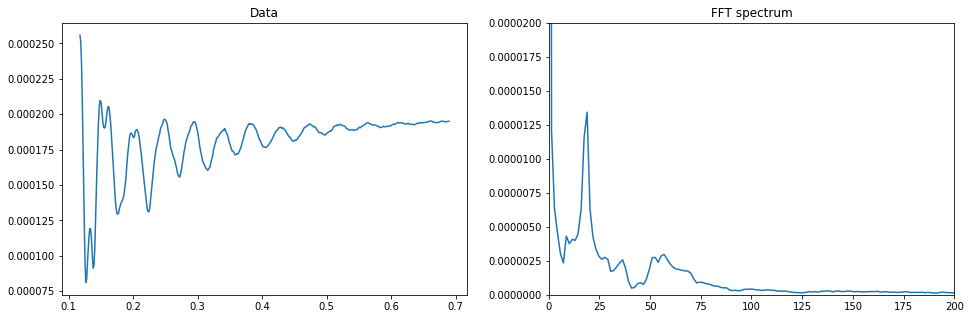

3.074845502403298


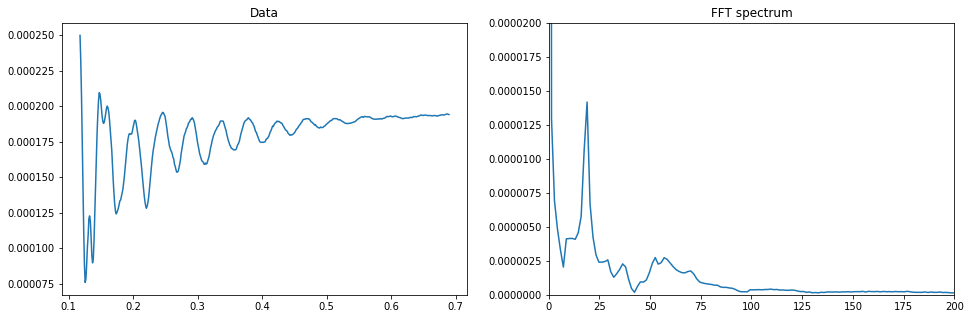

3.187457084000919


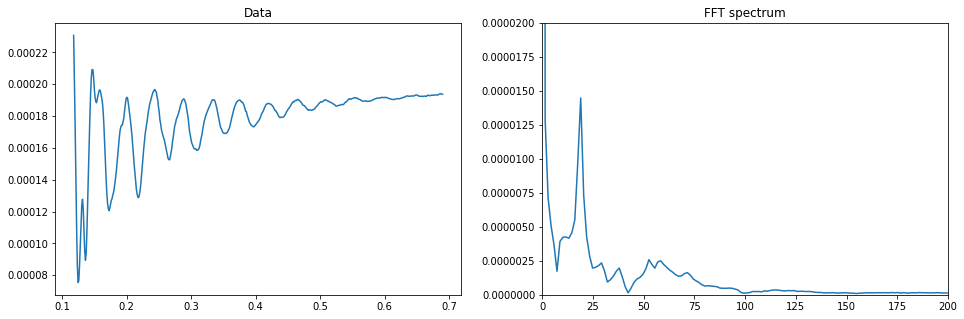

3.30006866559854


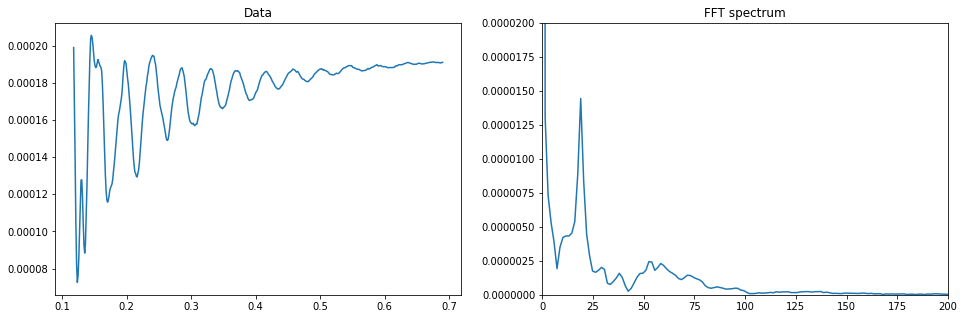

3.4126802471961537


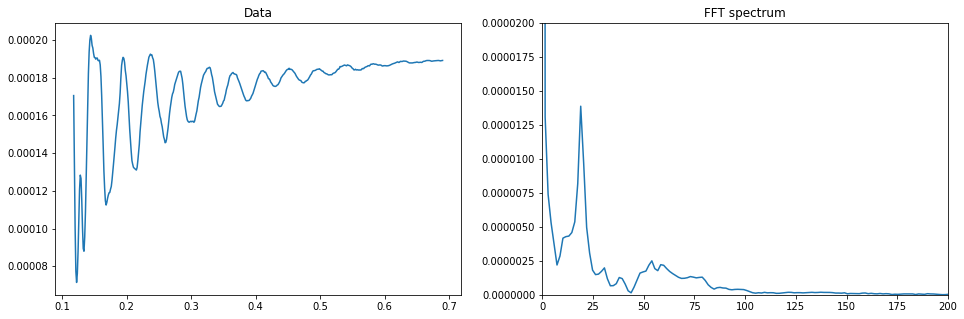

3.5252918287937747


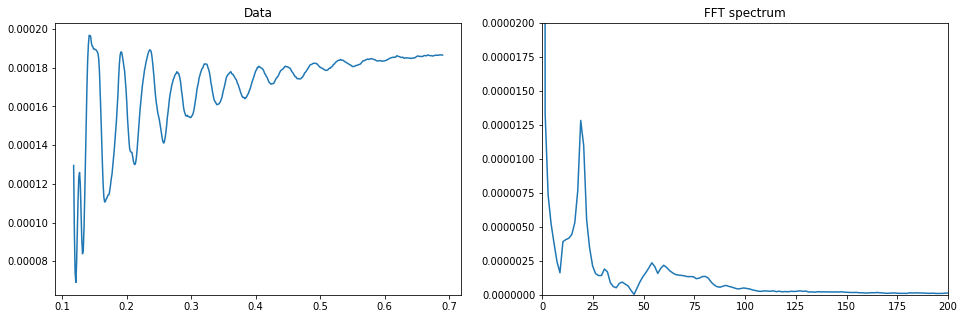

3.6379034103913956


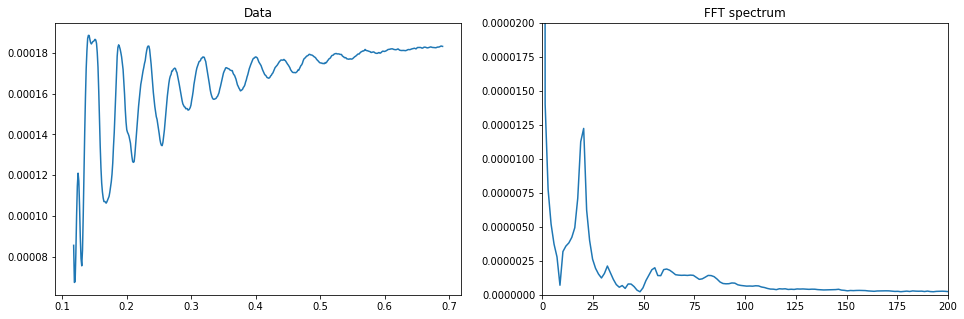

3.7495994506752095


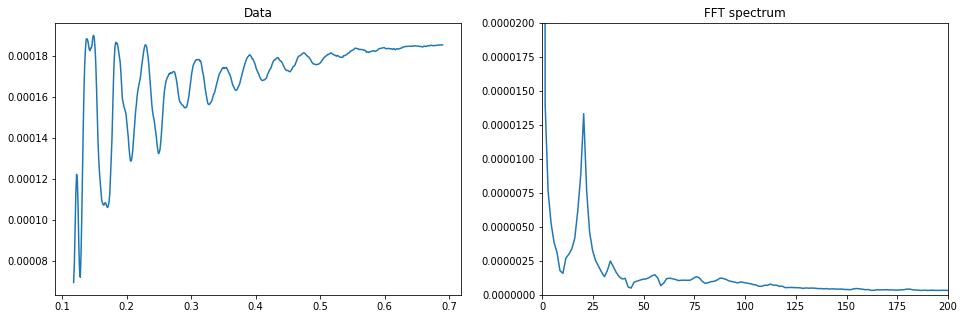

In [189]:
for lbl,grp in cdf.groupby('Topgate Voltage / V'):
    print(lbl)
    fft_SdH(grp,'Measured Field / T','DC Voltage xx / V',1.45,8.49,N=501,xlim=200,ylim=2e-5,fit=False)

# Hallbar 2

Density and mobility from Rxy:
n = 7.27e+12 cm^-2
mu = 109435.62 cm^2/Vs


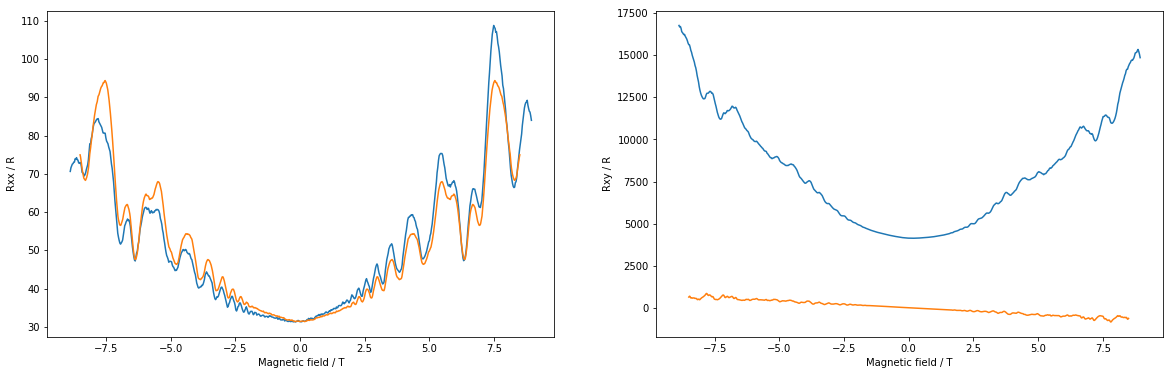

In [911]:
## Load data
loadin("20180705T135436318Z-0092.json")
cdf = df['0092'][(df['0092']['i'] > 334) & (df['0092']['i'] < 996)] # Remove double passes

Rxx = cdf['AC Voltage xx / V']/10e-9
Rxy = cdf['AC Voltage xy / V']/10e-9
Bmeas = cdf['Measured Field / T']

rho = cdf.iloc[cdf['Measured Field / T'].abs().argsort()[:1]]['AC Voltage xx / V'].values[0]/10e-9/4.

fxx = sp.interpolate.interp1d(Bmeas,Rxx)
fxy = sp.interpolate.interp1d(Bmeas,Rxy)
B = np.linspace(-8.5,8.5,1001)
# Split even and odd parts (to correct of geometry effects)
Rxx_even = (fxx(B)+fxx(-B))/2
Rxy_odd = (fxy(B)-fxy(-B))/2

idx= [len(Rxy_odd)//2,len(Rxy_odd)//2+50]
[Rxy_slope,Rxy_offset] = np.polyfit(B[idx[0]:idx[1]],-Rxy_odd[idx[0]:idx[1]],1)

## Plot
fig_2a, ax_2a = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
for ax,plot,ylbl in zip([ax_2a[0]]*2+[ax_2a[1]]*2,[(Bmeas,Rxx), (B,Rxx_even),(Bmeas,Rxy),(B,Rxy_odd)],['Rxx / R','Rxx / R','Rxy / R','Rxy / R']):
    ax.plot(*plot)
    ax.set_xlabel('Magnetic field / T')
    ax.set_ylabel(ylbl)
    
# Save figure
fig_2a.savefig('../plots/hallbar2_rxx_rxy.png')

## Overal density and mobility
n_total = 1/Rxy_slope/e ## Rxy slope
mu_total = 1/(rho*n_total*1e-4*e)
print('Density and mobility from Rxy:\nn = {0:.2e} '.format(n_total*1e-4)+'cm^-2')
print('mu'+' = {0:.2f} '.format(mu_total)+'cm^2/Vs')

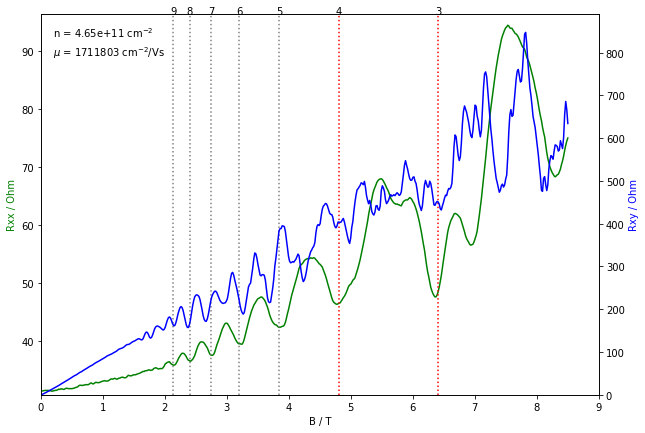

In [922]:
## Filling factors
Bsdh = {0:[2.13,2.4,2.74,3.22,3.85]} # Shubnikov- de Haas minima from Rxy
Bsdh_extra = {0:[4.80771365747044,6.410284876627254]}

[nu_band1, n_band1, mu_band1], [B_nu,nu_all] = single_subband(Bsdh,rho)
_, [B_nu_extra,nu_all_extra] = single_subband(Bsdh_extra,rho)

## Make overview plot
fig_2b, ax_2b = plt.subplots(figsize=(10,7))
xmax = [min(Rxx_even)*0.98,0]
ymax = [max(Rxx_even)*1.02,max(Rxy_odd)*1.05]
for ax,ylims,f,color,label in zip([ax_2b,ax_2b.twinx()],
                    [(xmax[0],ymax[0]),(xmax[1],ymax[1])],
                    [Rxx_even,-Rxy_odd],['green','blue'],
                    ['Rxx / Ohm','Rxy / Ohm']):
    ax.set_xlim(0,9)
    ax.set_ylim(*ylims)
    ax.plot(B,f,color=color)
    ax.set_xlabel('B / T')
    ax.set_ylabel(label,color=color)

# Density and mobility annotation
ax_2b.annotate('n = {0:.2e} '.format(n_band1[0])+u'cm$^{-2}$',(0.2,ymax[0]*0.96))
ax_2b.annotate(u'${\mu}$'+' = {0:.0f} '.format(mu_band1[0])+u'cm$^{-2}$/Vs',(0.2,ymax[0]*0.925))

# Filling factors
for xc,nuc in zip(B_nu,nu_all):
    ax_2b.axvline(x=xc,color='gray',ls=':')
    ax_2b.annotate('{0:.0f}'.format(nuc),(xc,ymax[0]),ha="center")
for xc,nuc in zip(B_nu_extra,nu_all_extra):
    ax_2b.axvline(x=xc,color='red',ls=':')
    ax_2b.annotate('{0:.0f}'.format(nuc),(xc,ymax[0]),ha="center")
    
# Save figure
fig_2b.savefig('../plots/hallbar2_subband1.png')
# print("n = {0}, mu = {1}".format(n*1e-4,mu))

In [943]:
# Select the positive up-sweep data
cdf = df['0092'][(df['0092']['i'] < 336)]
# Interpolate data
Vxx = scipy.interpolate.interp1d(1/cdf['Measured Field / T'],cdf['AC Voltage xx / V'],kind='linear')

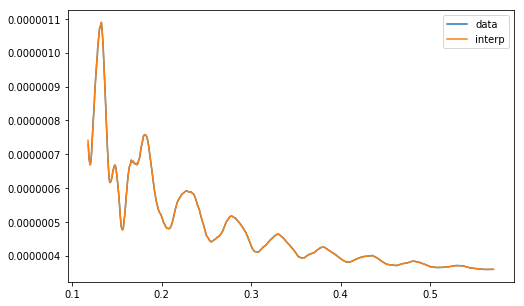

In [945]:
# Set 1/B range and sampling grid
start,end = 1/8.5,1/1.75
N = 1001
dB = (end - start) / N # Sample spacing
B = np.linspace(start,end,N)
tdf = cdf[(1/cdf['Measured Field / T'] > start)&(1/cdf['Measured Field / T'] < end)]

# plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(1/tdf['Measured Field / T'], tdf['AC Voltage xx / V'], label='data')
ax.plot(B,Vxx(B), '-',label='interp')
plt.legend()
plt.show()

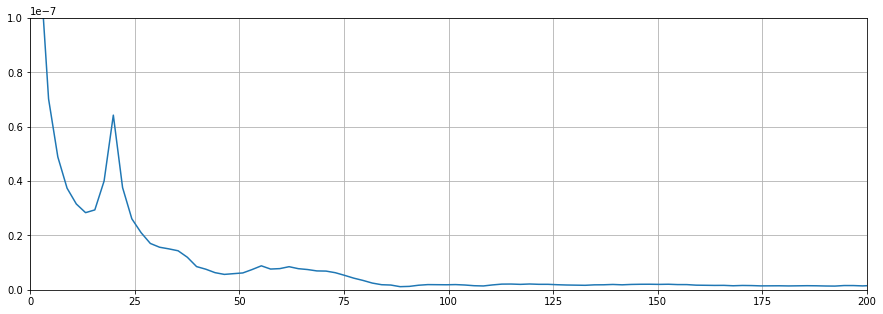

In [957]:
x = np.linspace(start,end,N)
y = Vxx(x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*dB), N//2)
pyf = 2.0/N * np.abs(yf[:N//2])

fig_fft, ax_fft = plt.subplots(figsize=(15,5))
ax_fft.plot(xf, pyf,'-')

ax_fft.set_xlim(0,200)
ax_fft.set_ylim(0,1e-7)
ax_fft.grid()
plt.show()

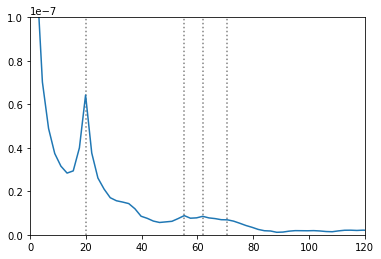

Subband 1 density: 4.81e+11
Subband 2 density: 1.34e+12
Subband 3 density: 1.50e+12
Subband 4 density: 1.71e+12
Total density is 5.02e+12 cm^-2


In [966]:
# Find peaks in Fourier spectrum
bounds = ([15,25],[40,60],[60,65],[70,80])
peaks = {}
for bnd,i in zip(bounds,range(len(bounds))):
    idx = [np.abs(xf - a0).argmin() for a0 in bnd]
    peaks['Subband '+str(i+1)] = xf[idx[0]+np.argmax(pyf[idx[0]:idx[1]])]

# Plot peaks
fig_peaks, ax_peaks = plt.subplots()
for key,peak in peaks.items():
    ax_peaks.axvline(x=peak,color='gray',ls=':')
ax_peaks.plot(xf, pyf,'-')
ax_peaks.set_xlim(0,120)
ax_peaks.set_ylim(0,1e-7)
plt.show()
    
# Calculate densities from found peaks    
for subband,period in peaks.items():
    n = period/Phi_0
    print(subband+' density: {0:.2e}'.format(n*1e-4))
print("Total density is {0:.2e} cm^-2".format(sum(peaks.values())/Phi_0*1e-4))

### Jsonl to JSON

In [ ]:
## Transform data from json to jsonl
fname = '20180709T061423208Z-0108'
# Add to dataset
dout_json = {}
dout_json['data'] = df['0108'].to_dict(orient='list')
# Export json file
with open('../processed/'+fname+'.json', 'w') as outfile:
    json.dump(dout_json, outfile)